Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

# Imports & Setting up directories

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH = "./"  # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive

    drive.mount("/content/drive")

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
    from src.autoencoder_train import *
    from src.autoencoder_plots import *
else:
    import sys

    sys.path.insert(0, "..")
    import os

    PATH = "../"
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
    from src.autoencoder_train import *
    from src.autoencoder_plots import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint

# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json
import os

# setting seeds
import random

In [3]:
%load_ext autoreload
%autoreload 2

#### AE alone

In [4]:
set_all_seeds(manualSeed=123, new_results=False)
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "fake"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
u_func.params["T"] = 1.5
u_func.params["f0"] = 0
u_func.params["f1"] = 2  # 4 # 1.4
u_func.params["scale"] = 0.0001  # for fake : 0.5 or 0.1 for real : 0.0001
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "newtonian"
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 1]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = False
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [300]
switch_steps = [500]
epoch_number = sum(switch_steps)  # total number of training epochs

Random Seed:  123
cpu


In [5]:
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [6]:
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=90, activation='tanh', config = 'latent') # 'x+sin(x)^2'
autoencoder.to(device)
count_parameters(autoencoder)

17826

In [7]:
H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2")
model = simple_HNN(input_dim=4, H_net=H_net, device=None)
model.to(device)

num_params = count_parameters(model)
print(num_params)

33303


In [8]:
q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(
    "cpu", init_method, time_steps, num_trajectories, u_func, g_func, None, Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp
)

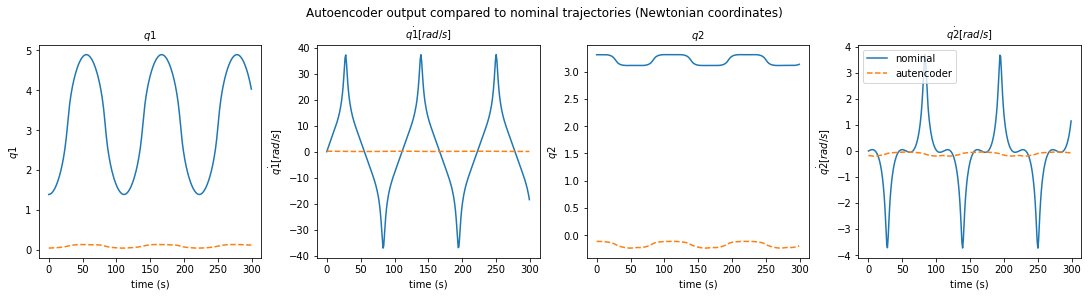

epoch    0 | train time 1.07 | train loss 2.843206e+02 
epoch   20 | train time 0.11 | train loss 2.064084e+02 
epoch   40 | train time 0.11 | train loss 1.506086e+02 


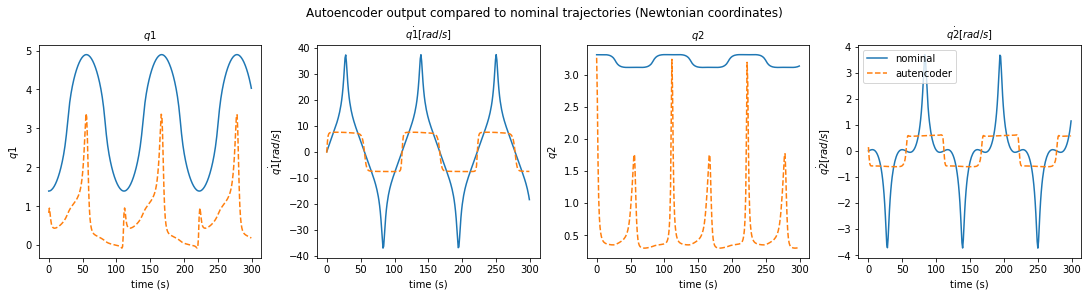

epoch   60 | train time 0.12 | train loss 1.211528e+02 
epoch   80 | train time 0.10 | train loss 9.632056e+01 


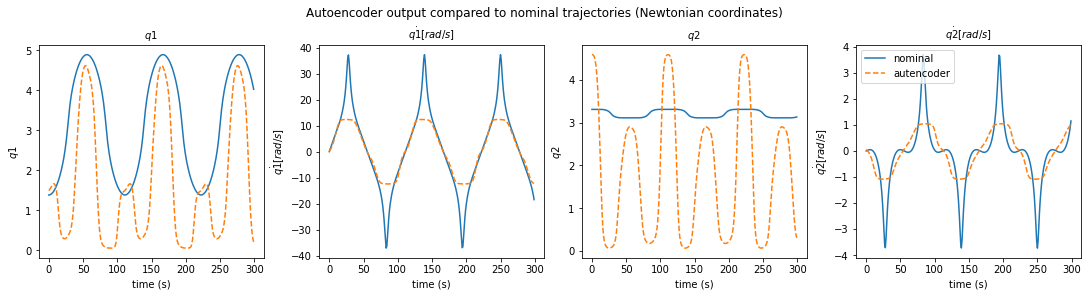

epoch  100 | train time 0.73 | train loss 7.803269e+01 
epoch  120 | train time 0.10 | train loss 6.444127e+01 
epoch  140 | train time 0.11 | train loss 5.418361e+01 


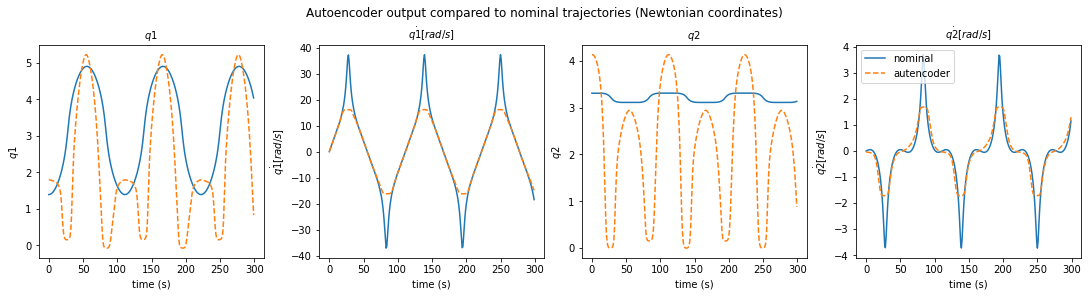

epoch  160 | train time 0.09 | train loss 4.615358e+01 
epoch  180 | train time 0.11 | train loss 3.968231e+01 


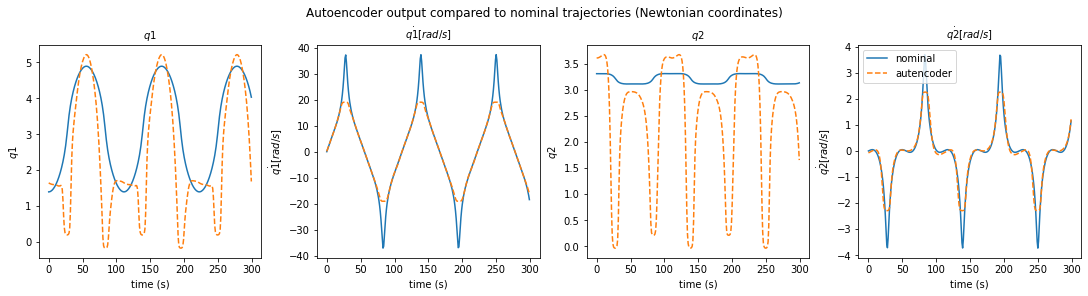

epoch  200 | train time 0.71 | train loss 3.434635e+01 
epoch  220 | train time 0.11 | train loss 2.987201e+01 
epoch  240 | train time 0.10 | train loss 2.611136e+01 


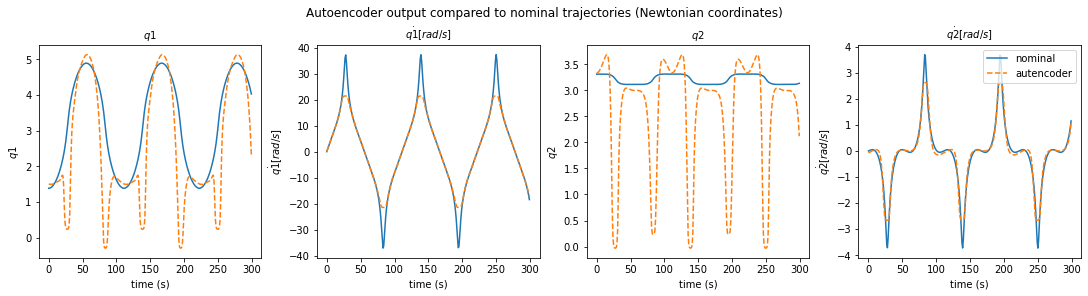

epoch  260 | train time 0.11 | train loss 2.298594e+01 
epoch  280 | train time 0.10 | train loss 2.039579e+01 


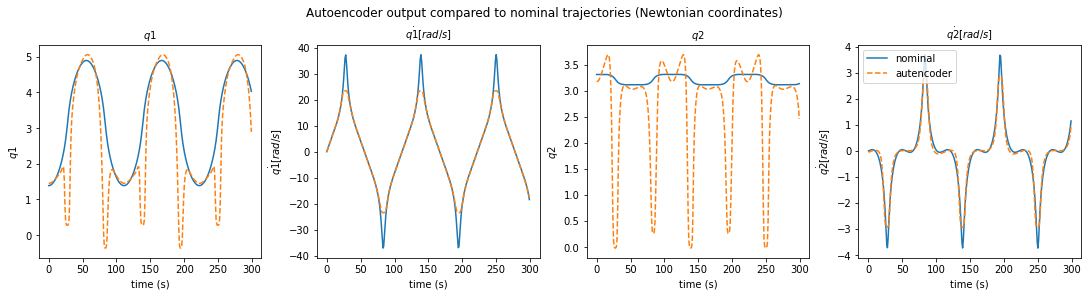

epoch  300 | train time 0.68 | train loss 1.820620e+01 
epoch  320 | train time 0.12 | train loss 1.632310e+01 
epoch  340 | train time 0.11 | train loss 1.470195e+01 


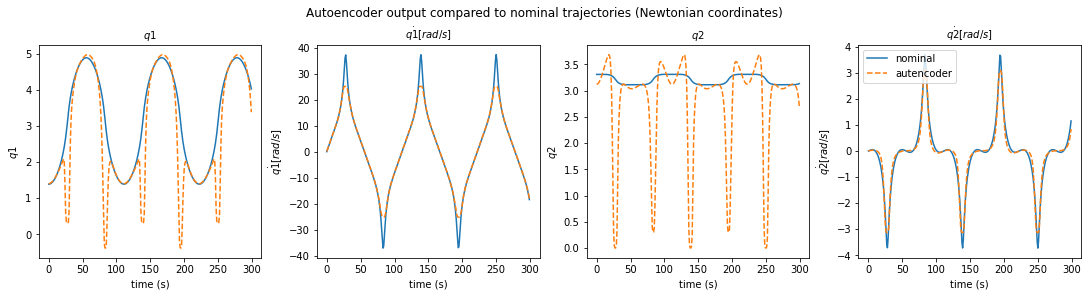

epoch  360 | train time 0.13 | train loss 1.328803e+01 
epoch  380 | train time 0.10 | train loss 1.204897e+01 


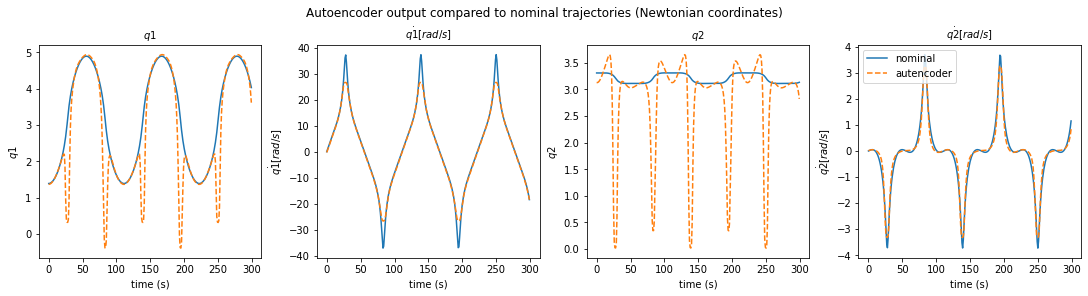

epoch  400 | train time 0.86 | train loss 1.100753e+01 
epoch  420 | train time 0.12 | train loss 1.000237e+01 
epoch  440 | train time 0.21 | train loss 9.150191e+00 


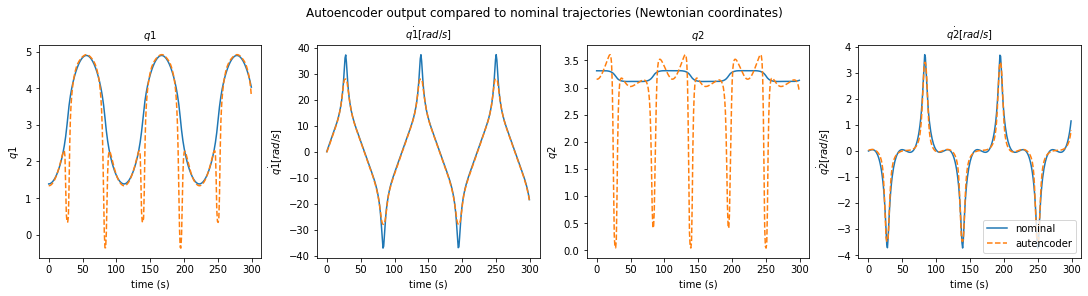

epoch  460 | train time 0.13 | train loss 8.407612e+00 
epoch  480 | train time 0.09 | train loss 7.713965e+00 


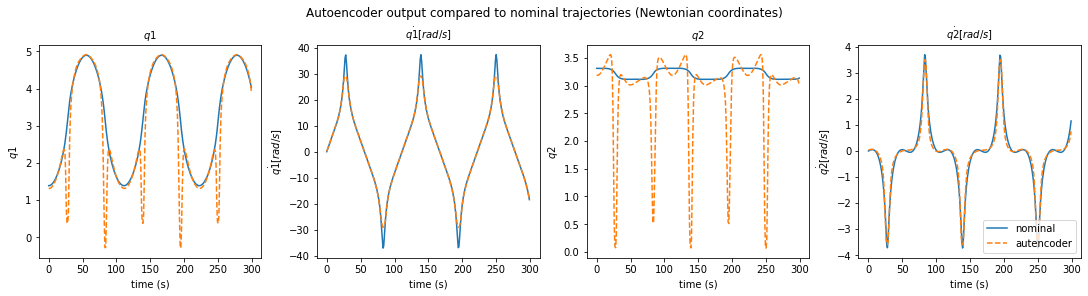

epoch  500 | train time 0.76 | train loss 7.106604e+00 
epoch  520 | train time 0.12 | train loss 6.587108e+00 
epoch  540 | train time 0.12 | train loss 6.068680e+00 


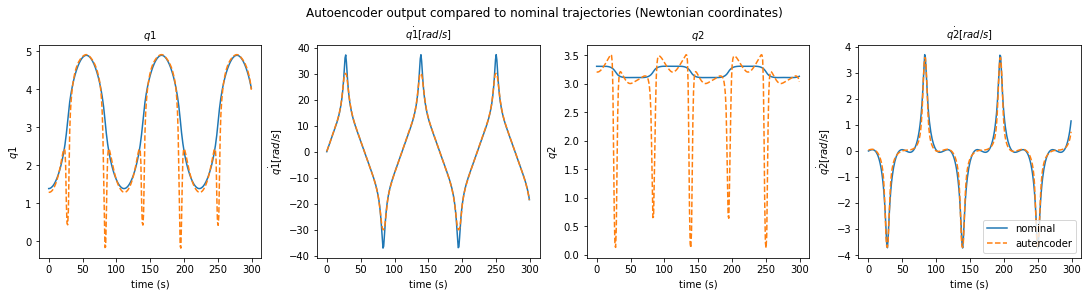

epoch  560 | train time 0.11 | train loss 5.618997e+00 
epoch  580 | train time 0.11 | train loss 5.286191e+00 


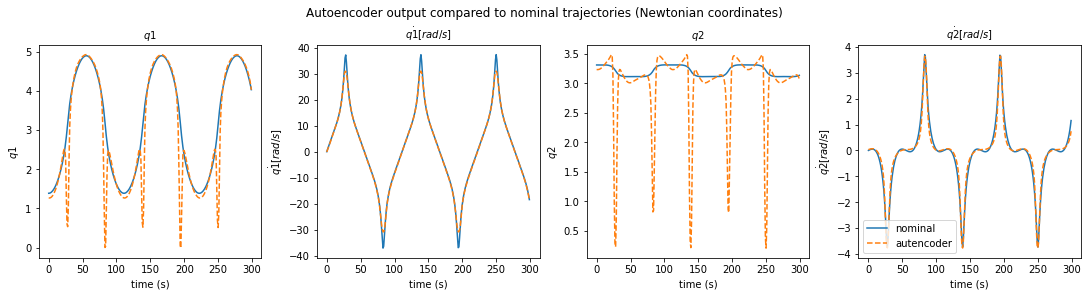

epoch  600 | train time 0.97 | train loss 4.870792e+00 
epoch  620 | train time 0.13 | train loss 4.518881e+00 
epoch  640 | train time 0.14 | train loss 4.214688e+00 


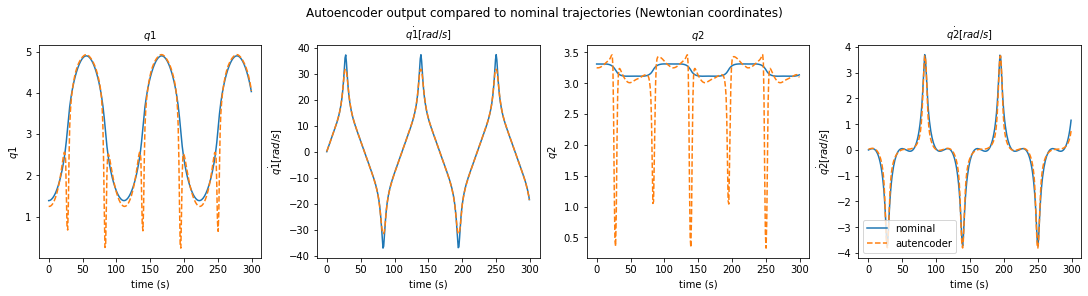

epoch  660 | train time 0.13 | train loss 3.936726e+00 
epoch  680 | train time 0.14 | train loss 3.682234e+00 


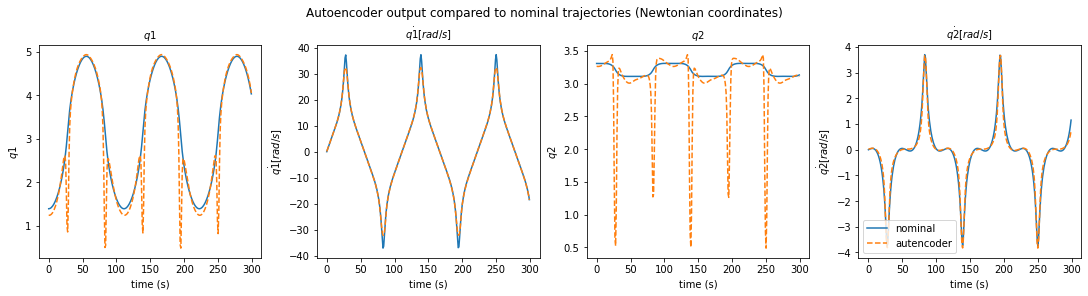

epoch  700 | train time 1.00 | train loss 3.448660e+00 
epoch  720 | train time 0.13 | train loss 3.238301e+00 
epoch  740 | train time 0.13 | train loss 3.048532e+00 


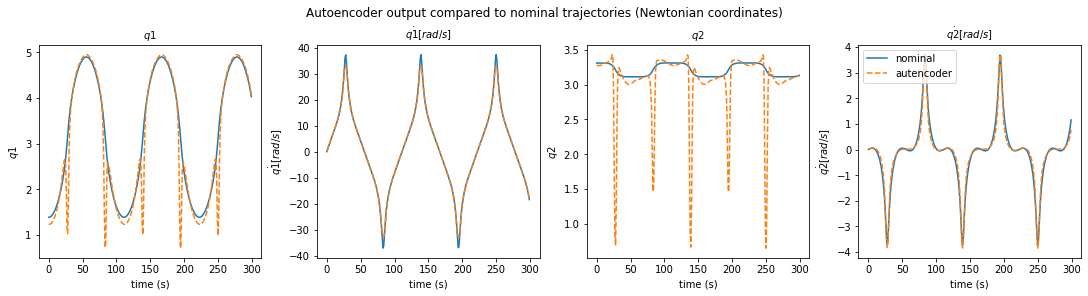

epoch  760 | train time 0.19 | train loss 2.864741e+00 
epoch  780 | train time 0.15 | train loss 2.688315e+00 


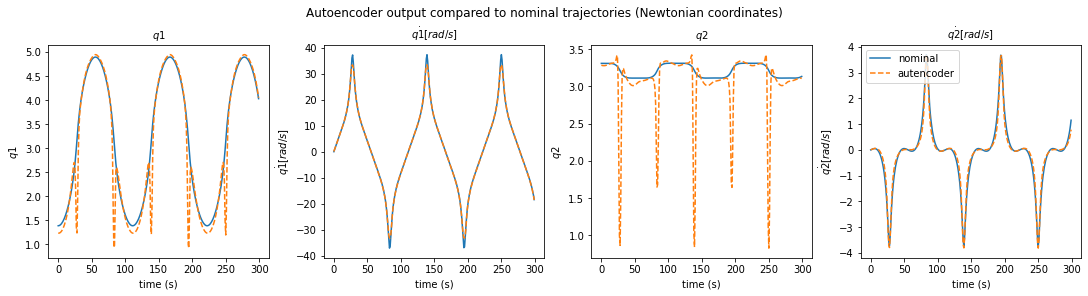

epoch  800 | train time 1.45 | train loss 2.531956e+00 
epoch  820 | train time 0.19 | train loss 2.387258e+00 
epoch  840 | train time 0.15 | train loss 2.252801e+00 


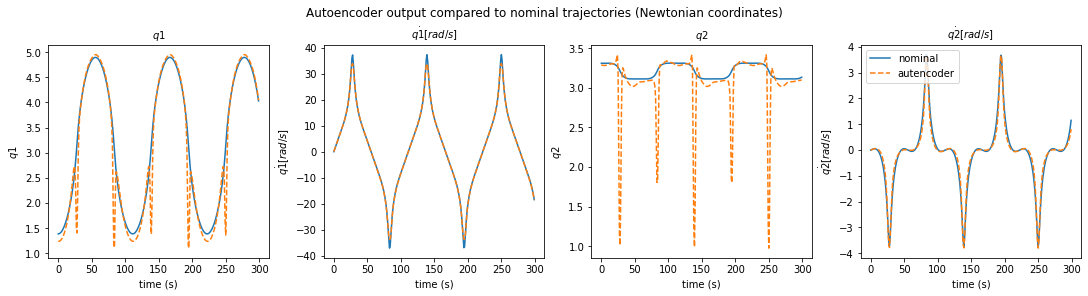

epoch  860 | train time 0.14 | train loss 2.272235e+00 
epoch  880 | train time 0.16 | train loss 2.034616e+00 


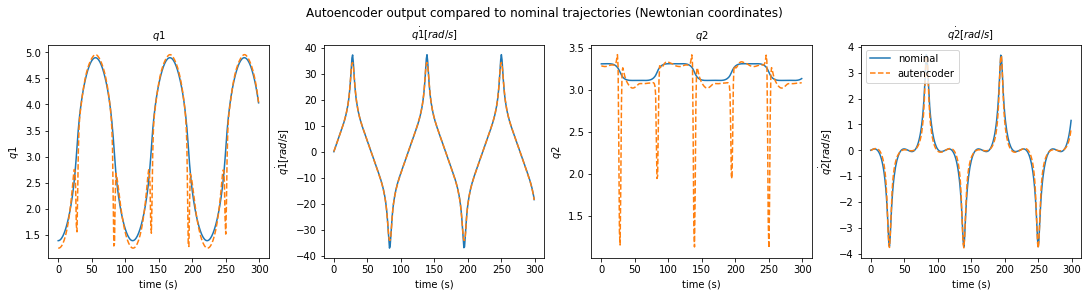

epoch  900 | train time 1.74 | train loss 1.904437e+00 
epoch  920 | train time 0.15 | train loss 1.803652e+00 
epoch  940 | train time 0.17 | train loss 1.708452e+00 


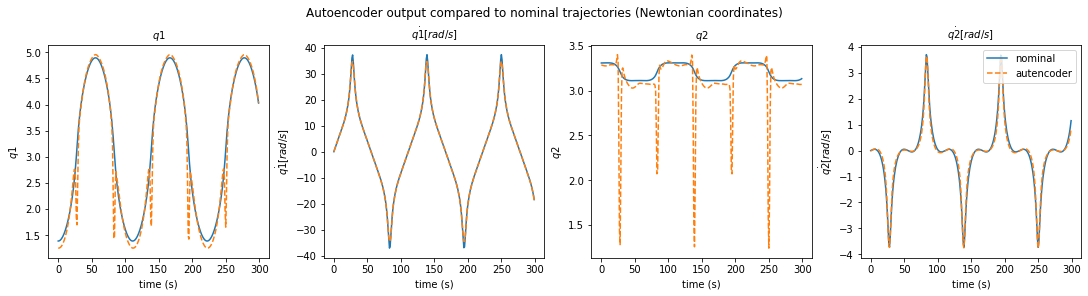

epoch  960 | train time 0.19 | train loss 1.619846e+00 
epoch  980 | train time 0.21 | train loss 1.536868e+00 


In [9]:
stats_2 = train_only_ae(autoencoder, 
                        model, 
                        device,
                        train_loader, 
                        test_loader, 
                        epochs= 1000, # 3000
                        horizon=300, 
                        lr = 1e-3,
                        w = torch.tensor([10.0,  1.0, 100.0, 1.0],device=device))

### plots

Standard deviation of each coordinate:  tensor([ 2.8774,  0.6174, 18.0585,  7.9428])


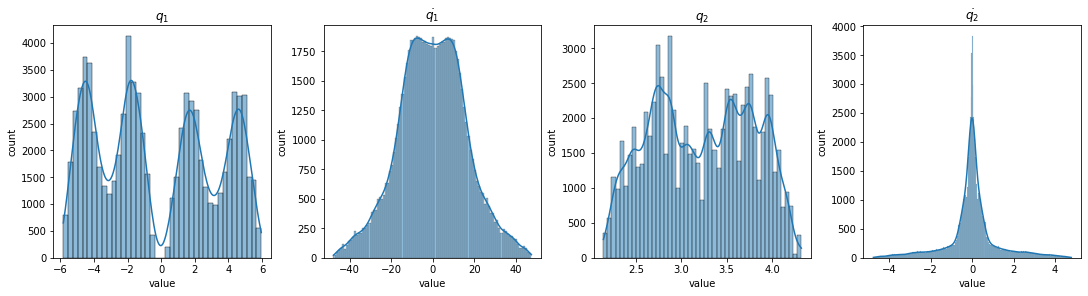

In [10]:
plot_distribution(train_loader, save=False, path=PATH+'data/ae_distributions.png')

#### AE and Latent_ODE_HNN

In [11]:
# model = load_model()
# count_parameters(model)

# autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'encoded') # 'x+sin(x)^2'
# autoencoder.to(device)
# count_parameters(autoencoder)

In [12]:
horizon_list = [20,50,70,90,110,130,150,170,190,210,230,250,270,290,300]
switch_steps = [200,500,500,200,200,200,200,300,300,200,200,200,200,200,200]
epoch_number = sum(switch_steps)
print(epoch_number)

3800


horizon length : 20


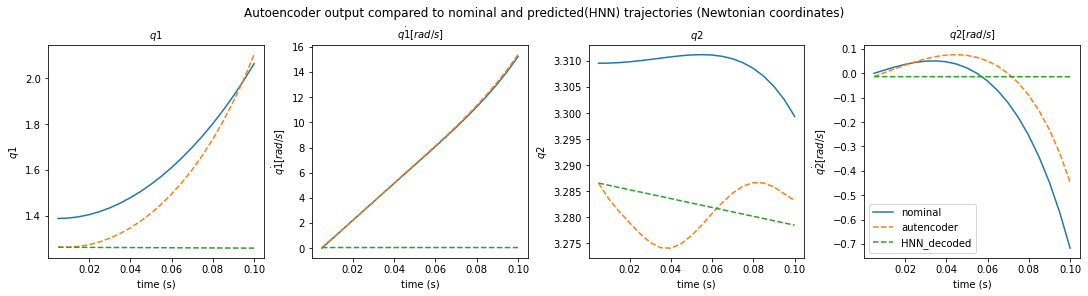

epoch    0 | train time 1.57 | train loss 1.028852e+02 
epoch    1 | train time 0.61 | train loss 1.094159e+02 
epoch    2 | train time 0.57 | train loss 8.757716e+01 
epoch    3 | train time 0.58 | train loss 7.529657e+01 
epoch    4 | train time 0.62 | train loss 8.004407e+01 
epoch    5 | train time 0.63 | train loss 7.738360e+01 
epoch    6 | train time 0.60 | train loss 6.952031e+01 
epoch    7 | train time 0.63 | train loss 6.792524e+01 
epoch    8 | train time 0.58 | train loss 7.147279e+01 
epoch    9 | train time 0.61 | train loss 7.221778e+01 


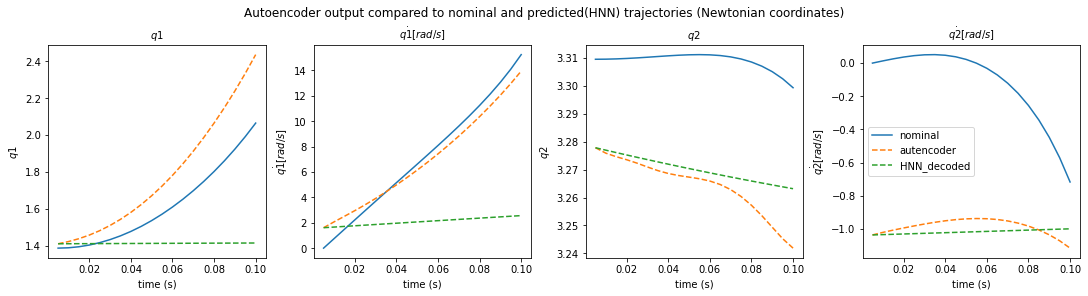

epoch   10 | train time 1.42 | train loss 6.916396e+01 
epoch   11 | train time 0.65 | train loss 6.715007e+01 
epoch   12 | train time 0.72 | train loss 6.805054e+01 
epoch   13 | train time 0.65 | train loss 6.890846e+01 
epoch   14 | train time 0.67 | train loss 6.759097e+01 
epoch   15 | train time 0.72 | train loss 6.541930e+01 
epoch   16 | train time 0.74 | train loss 6.421215e+01 
epoch   17 | train time 0.63 | train loss 6.426624e+01 
epoch   18 | train time 0.71 | train loss 6.395900e+01 
epoch   19 | train time 0.65 | train loss 6.229283e+01 


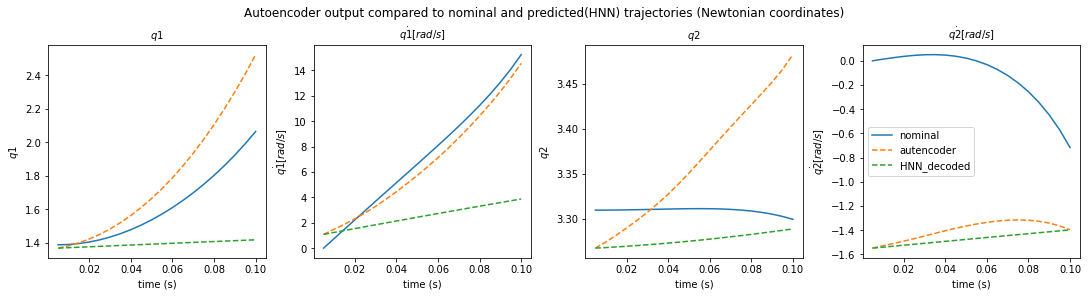

epoch   20 | train time 1.48 | train loss 6.063619e+01 
epoch   21 | train time 0.68 | train loss 6.008580e+01 
epoch   22 | train time 0.70 | train loss 6.012437e+01 
epoch   23 | train time 0.65 | train loss 5.969199e+01 
epoch   24 | train time 0.65 | train loss 5.854235e+01 
epoch   25 | train time 0.62 | train loss 5.770394e+01 
epoch   26 | train time 0.63 | train loss 5.752014e+01 
epoch   27 | train time 0.63 | train loss 5.746664e+01 
epoch   28 | train time 0.65 | train loss 5.687432e+01 
epoch   29 | train time 0.67 | train loss 5.608162e+01 


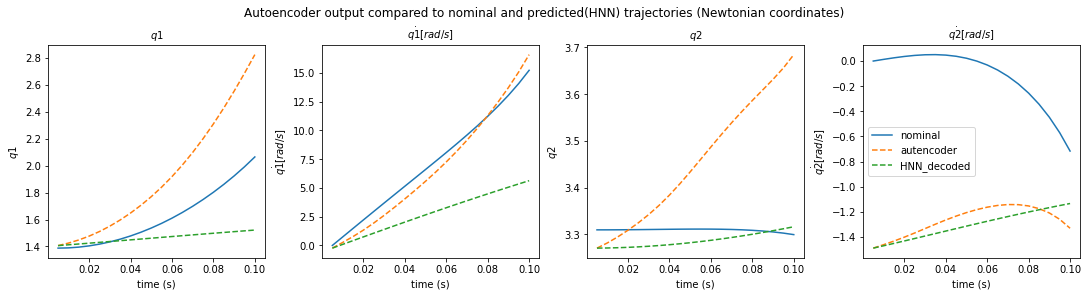

epoch   30 | train time 1.44 | train loss 5.567295e+01 
epoch   31 | train time 0.63 | train loss 5.528963e+01 
epoch   32 | train time 0.63 | train loss 5.479319e+01 
epoch   33 | train time 0.88 | train loss 5.422258e+01 
epoch   34 | train time 0.82 | train loss 5.373207e+01 
epoch   35 | train time 0.76 | train loss 5.344375e+01 
epoch   36 | train time 0.79 | train loss 5.300740e+01 
epoch   37 | train time 0.74 | train loss 5.238754e+01 
epoch   38 | train time 0.75 | train loss 5.179043e+01 
epoch   39 | train time 0.75 | train loss 5.133115e+01 


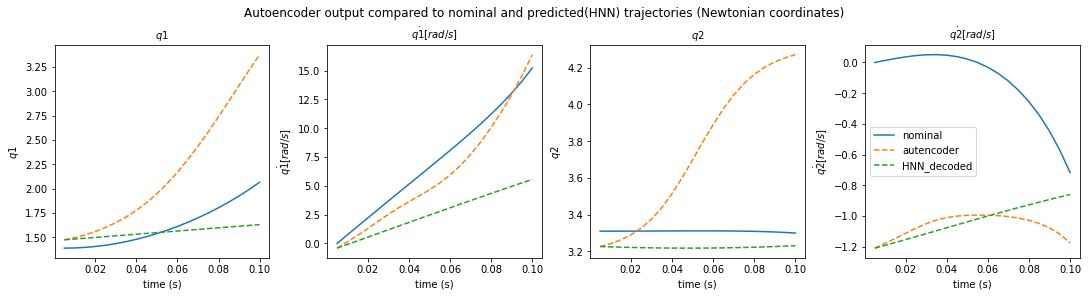

epoch   40 | train time 2.02 | train loss 5.071088e+01 
epoch   41 | train time 0.85 | train loss 5.009937e+01 
epoch   42 | train time 0.86 | train loss 4.967747e+01 
epoch   43 | train time 0.82 | train loss 4.904556e+01 
epoch   44 | train time 0.84 | train loss 4.852174e+01 
epoch   45 | train time 0.98 | train loss 4.809903e+01 
epoch   46 | train time 0.80 | train loss 4.760321e+01 
epoch   47 | train time 0.85 | train loss 4.714723e+01 
epoch   48 | train time 0.86 | train loss 4.665636e+01 
epoch   49 | train time 0.84 | train loss 4.612187e+01 


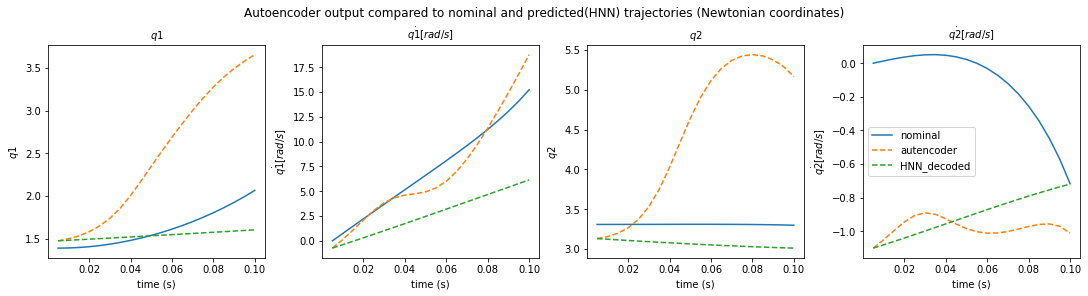

epoch   50 | train time 2.39 | train loss 4.574130e+01 
epoch   51 | train time 0.86 | train loss 4.527633e+01 
epoch   52 | train time 0.83 | train loss 4.485086e+01 
epoch   53 | train time 0.78 | train loss 4.450047e+01 
epoch   54 | train time 0.82 | train loss 4.416781e+01 
epoch   55 | train time 0.80 | train loss 4.392166e+01 
epoch   56 | train time 0.74 | train loss 4.362504e+01 
epoch   57 | train time 0.80 | train loss 4.328802e+01 
epoch   58 | train time 0.86 | train loss 4.277856e+01 
epoch   59 | train time 0.81 | train loss 4.248659e+01 


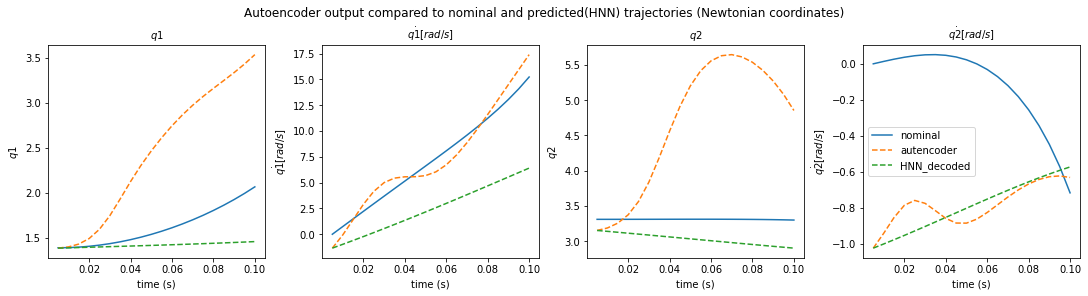

epoch   60 | train time 1.83 | train loss 4.223912e+01 
epoch   61 | train time 0.84 | train loss 4.169135e+01 
epoch   62 | train time 0.76 | train loss 4.141798e+01 
epoch   63 | train time 0.64 | train loss 4.110371e+01 
epoch   64 | train time 0.70 | train loss 4.057042e+01 
epoch   65 | train time 0.70 | train loss 4.032266e+01 
epoch   66 | train time 0.70 | train loss 3.987940e+01 
epoch   67 | train time 0.73 | train loss 3.949884e+01 
epoch   68 | train time 0.71 | train loss 3.918675e+01 
epoch   69 | train time 0.65 | train loss 3.871488e+01 


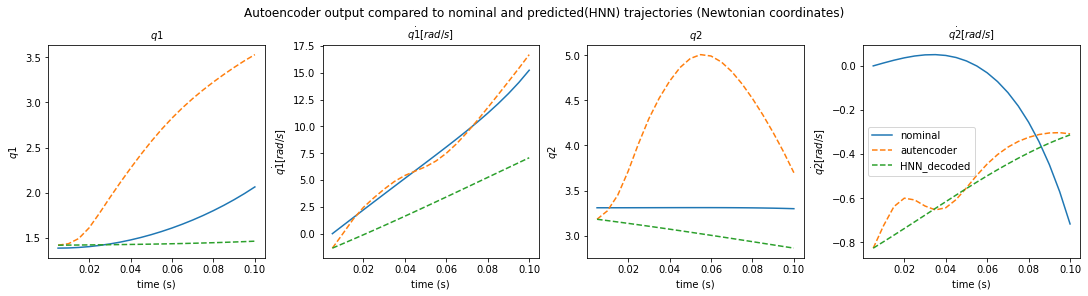

epoch   70 | train time 1.47 | train loss 3.841523e+01 
epoch   71 | train time 0.64 | train loss 3.800023e+01 
epoch   72 | train time 0.68 | train loss 3.764653e+01 
epoch   73 | train time 0.66 | train loss 3.731742e+01 
epoch   74 | train time 0.76 | train loss 3.692003e+01 
epoch   75 | train time 0.73 | train loss 3.661524e+01 
epoch   76 | train time 0.86 | train loss 3.625853e+01 
epoch   77 | train time 0.79 | train loss 3.587632e+01 
epoch   78 | train time 0.94 | train loss 3.558182e+01 
epoch   79 | train time 0.85 | train loss 3.524096e+01 


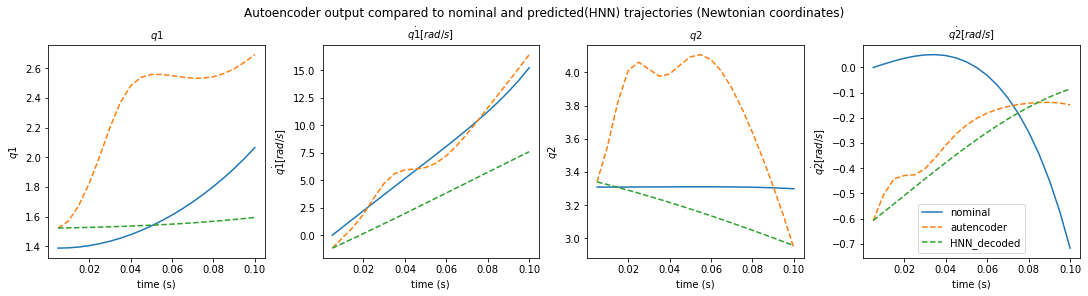

epoch   80 | train time 1.85 | train loss 3.488564e+01 
epoch   81 | train time 0.93 | train loss 3.457567e+01 
epoch   82 | train time 0.88 | train loss 3.424699e+01 
epoch   83 | train time 0.77 | train loss 3.392518e+01 
epoch   84 | train time 0.80 | train loss 3.362664e+01 
epoch   85 | train time 0.80 | train loss 3.330531e+01 
epoch   86 | train time 0.83 | train loss 3.298314e+01 
epoch   87 | train time 0.90 | train loss 3.270864e+01 
epoch   88 | train time 0.82 | train loss 3.243304e+01 
epoch   89 | train time 0.82 | train loss 3.214866e+01 


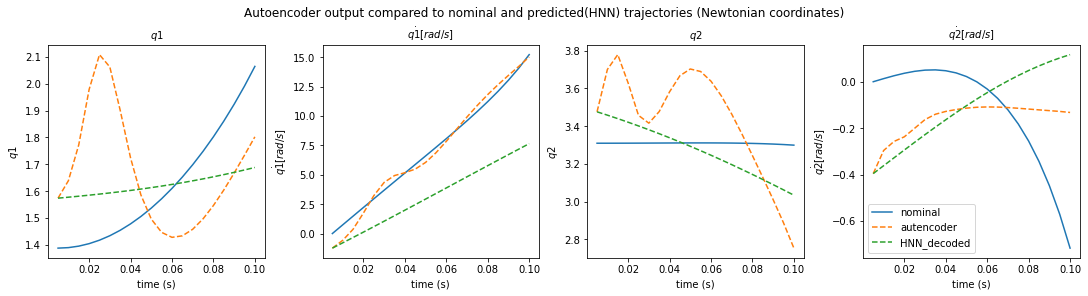

epoch   90 | train time 1.80 | train loss 3.192823e+01 
epoch   91 | train time 0.67 | train loss 3.184928e+01 
epoch   92 | train time 0.71 | train loss 3.184496e+01 
epoch   93 | train time 0.68 | train loss 3.168393e+01 
epoch   94 | train time 0.66 | train loss 3.102231e+01 
epoch   95 | train time 0.66 | train loss 3.057229e+01 
epoch   96 | train time 0.73 | train loss 3.067881e+01 
epoch   97 | train time 0.69 | train loss 3.042311e+01 
epoch   98 | train time 0.86 | train loss 2.989598e+01 
epoch   99 | train time 0.84 | train loss 2.978665e+01 


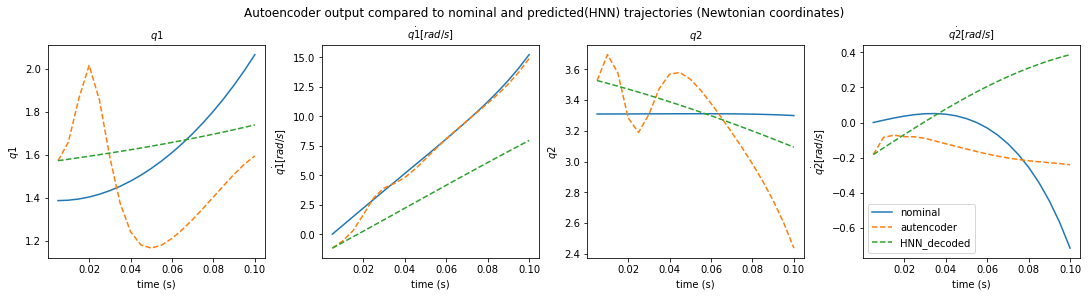

epoch  100 | train time 1.63 | train loss 2.967820e+01 
epoch  101 | train time 0.72 | train loss 2.934518e+01 
epoch  102 | train time 0.71 | train loss 2.905013e+01 
epoch  103 | train time 0.69 | train loss 2.894157e+01 
epoch  104 | train time 0.69 | train loss 2.877324e+01 
epoch  105 | train time 0.76 | train loss 2.841268e+01 
epoch  106 | train time 0.68 | train loss 2.828213e+01 
epoch  107 | train time 0.72 | train loss 2.816770e+01 
epoch  108 | train time 0.72 | train loss 2.788860e+01 
epoch  109 | train time 0.73 | train loss 2.768873e+01 


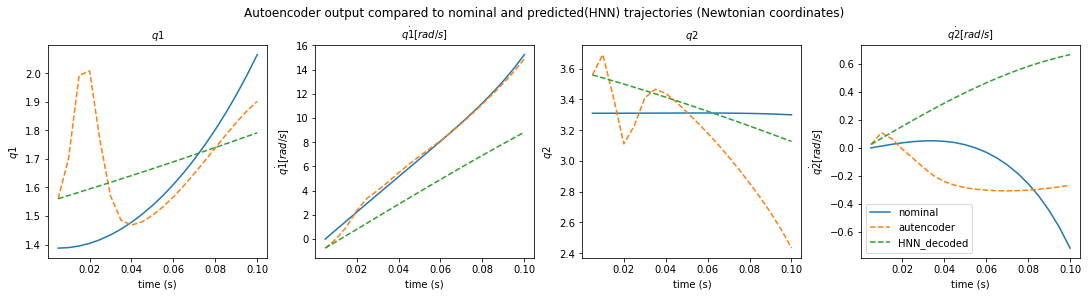

epoch  110 | train time 1.62 | train loss 2.754723e+01 
epoch  111 | train time 0.82 | train loss 2.739064e+01 
epoch  112 | train time 0.68 | train loss 2.717877e+01 
epoch  113 | train time 0.65 | train loss 2.696958e+01 
epoch  114 | train time 0.73 | train loss 2.686336e+01 
epoch  115 | train time 0.70 | train loss 2.669944e+01 
epoch  116 | train time 0.72 | train loss 2.650237e+01 
epoch  117 | train time 0.65 | train loss 2.632688e+01 
epoch  118 | train time 0.64 | train loss 2.617466e+01 
epoch  119 | train time 0.68 | train loss 2.605386e+01 


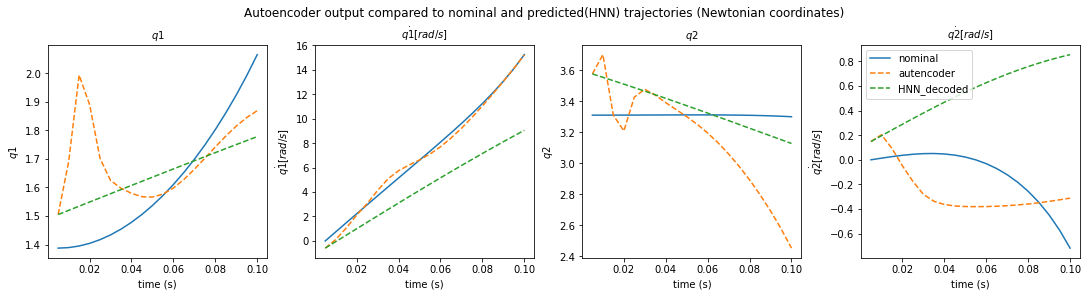

epoch  120 | train time 1.43 | train loss 2.588830e+01 
epoch  121 | train time 0.66 | train loss 2.570960e+01 
epoch  122 | train time 0.58 | train loss 2.555062e+01 
epoch  123 | train time 0.59 | train loss 2.539183e+01 
epoch  124 | train time 0.57 | train loss 2.526207e+01 
epoch  125 | train time 0.60 | train loss 2.513491e+01 
epoch  126 | train time 0.56 | train loss 2.499469e+01 
epoch  127 | train time 0.60 | train loss 2.486909e+01 
epoch  128 | train time 0.63 | train loss 2.473487e+01 
epoch  129 | train time 0.75 | train loss 2.461271e+01 


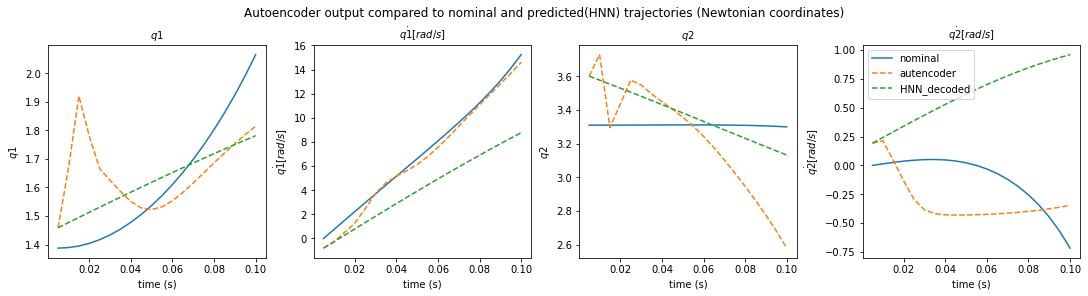

epoch  130 | train time 1.75 | train loss 2.450924e+01 
epoch  131 | train time 0.64 | train loss 2.442761e+01 
epoch  132 | train time 0.67 | train loss 2.438544e+01 
epoch  133 | train time 0.67 | train loss 2.437601e+01 
epoch  134 | train time 0.62 | train loss 2.433804e+01 
epoch  135 | train time 0.63 | train loss 2.420364e+01 
epoch  136 | train time 0.60 | train loss 2.390263e+01 
epoch  137 | train time 0.69 | train loss 2.354378e+01 
epoch  138 | train time 0.60 | train loss 2.334745e+01 
epoch  139 | train time 0.64 | train loss 2.333306e+01 


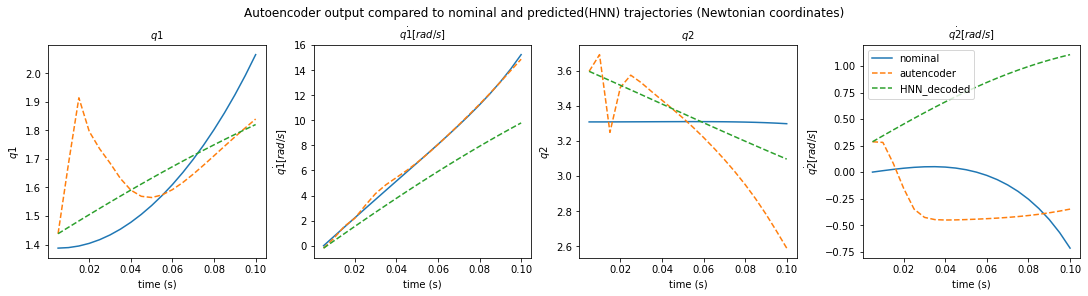

epoch  140 | train time 1.49 | train loss 2.335483e+01 
epoch  141 | train time 0.73 | train loss 2.327531e+01 
epoch  142 | train time 0.64 | train loss 2.306127e+01 
epoch  143 | train time 0.65 | train loss 2.279830e+01 
epoch  144 | train time 0.71 | train loss 2.265077e+01 
epoch  145 | train time 0.69 | train loss 2.260690e+01 
epoch  146 | train time 0.74 | train loss 2.258511e+01 
epoch  147 | train time 1.04 | train loss 2.249785e+01 
epoch  148 | train time 0.91 | train loss 2.232361e+01 
epoch  149 | train time 0.89 | train loss 2.212847e+01 


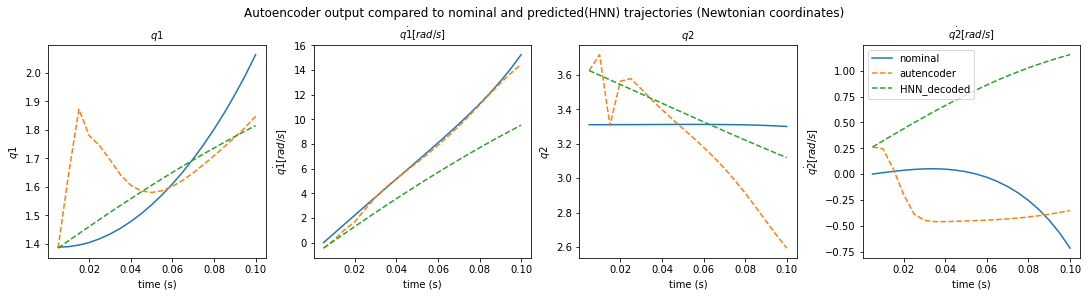

epoch  150 | train time 1.86 | train loss 2.196978e+01 
epoch  151 | train time 0.74 | train loss 2.186286e+01 
epoch  152 | train time 0.89 | train loss 2.180196e+01 
epoch  153 | train time 0.81 | train loss 2.174620e+01 
epoch  154 | train time 0.78 | train loss 2.167179e+01 
epoch  155 | train time 0.81 | train loss 2.157965e+01 
epoch  156 | train time 0.78 | train loss 2.146911e+01 
epoch  157 | train time 0.90 | train loss 2.133852e+01 
epoch  158 | train time 0.88 | train loss 2.120559e+01 
epoch  159 | train time 0.72 | train loss 2.106560e+01 


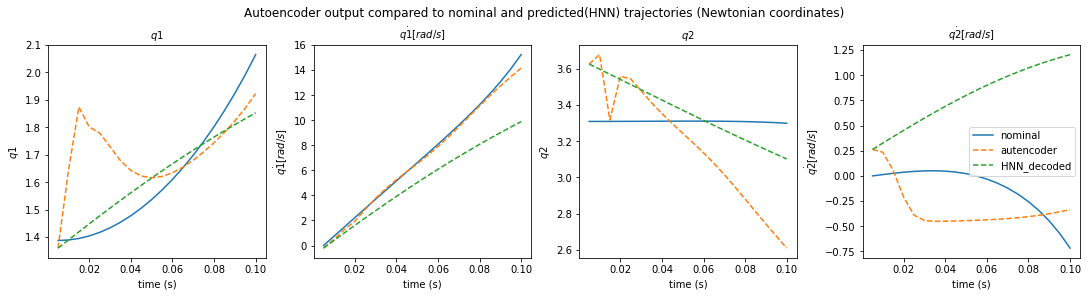

epoch  160 | train time 2.16 | train loss 2.092824e+01 
epoch  161 | train time 0.82 | train loss 2.079944e+01 
epoch  162 | train time 1.04 | train loss 2.067984e+01 
epoch  163 | train time 1.12 | train loss 2.056663e+01 
epoch  164 | train time 1.20 | train loss 2.046517e+01 
epoch  165 | train time 0.86 | train loss 2.038195e+01 
epoch  166 | train time 0.73 | train loss 2.033789e+01 
epoch  167 | train time 0.76 | train loss 2.037384e+01 
epoch  168 | train time 0.69 | train loss 2.058823e+01 
epoch  169 | train time 0.79 | train loss 2.106446e+01 


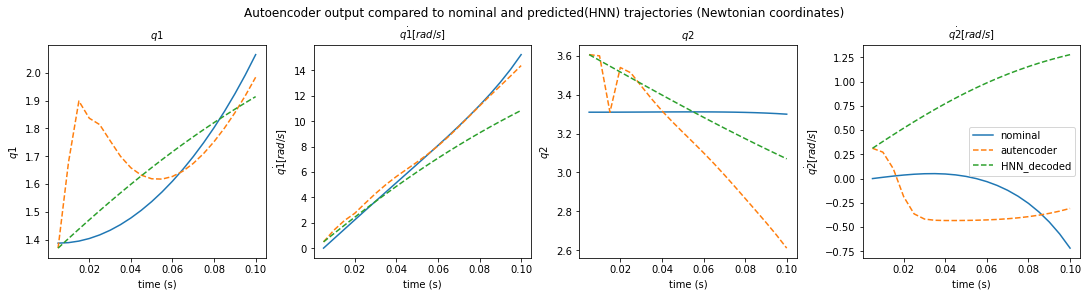

epoch  170 | train time 1.99 | train loss 2.159966e+01 
epoch  171 | train time 0.79 | train loss 2.128565e+01 
epoch  172 | train time 0.89 | train loss 2.015932e+01 
epoch  173 | train time 0.78 | train loss 1.951506e+01 
epoch  174 | train time 0.75 | train loss 1.999999e+01 
epoch  175 | train time 0.68 | train loss 2.037826e+01 
epoch  176 | train time 0.76 | train loss 1.996636e+01 
epoch  177 | train time 0.72 | train loss 1.920207e+01 
epoch  178 | train time 0.64 | train loss 1.934125e+01 
epoch  179 | train time 0.70 | train loss 1.959468e+01 


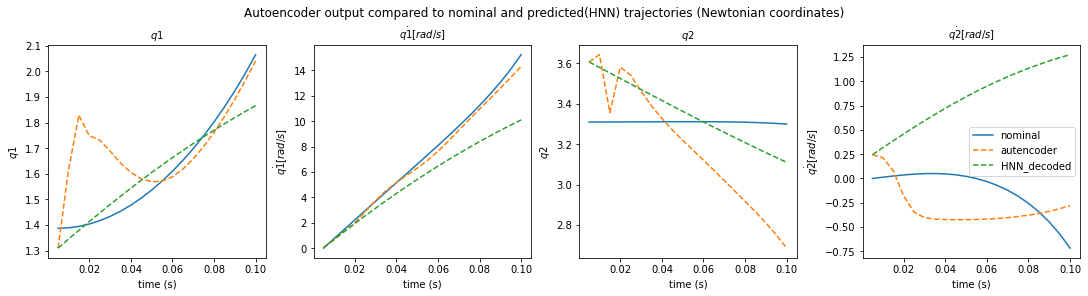

epoch  180 | train time 1.88 | train loss 1.927893e+01 
epoch  181 | train time 0.77 | train loss 1.877377e+01 
epoch  182 | train time 0.73 | train loss 1.901339e+01 
epoch  183 | train time 0.73 | train loss 1.896028e+01 
epoch  184 | train time 0.75 | train loss 1.864460e+01 
epoch  185 | train time 0.73 | train loss 1.847324e+01 
epoch  186 | train time 0.73 | train loss 1.857717e+01 
epoch  187 | train time 0.77 | train loss 1.848261e+01 
epoch  188 | train time 0.82 | train loss 1.815171e+01 
epoch  189 | train time 0.83 | train loss 1.813750e+01 


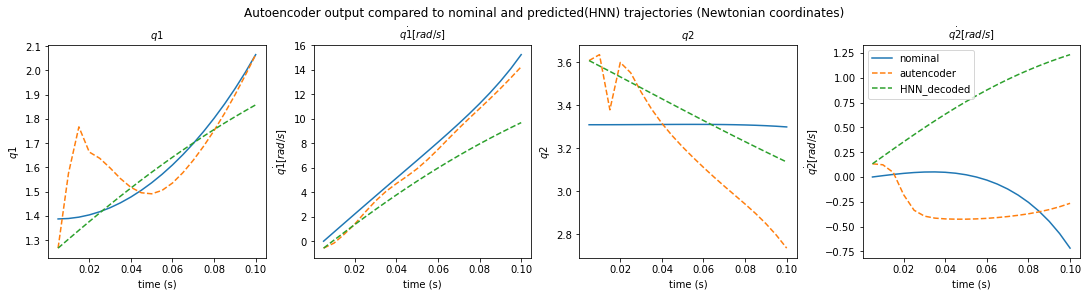

epoch  190 | train time 2.14 | train loss 1.817455e+01 
epoch  191 | train time 0.81 | train loss 1.796941e+01 
epoch  192 | train time 0.88 | train loss 1.779900e+01 
epoch  193 | train time 0.86 | train loss 1.776487e+01 
epoch  194 | train time 0.77 | train loss 1.775048e+01 
epoch  195 | train time 0.91 | train loss 1.758569e+01 
epoch  196 | train time 0.91 | train loss 1.742629e+01 
epoch  197 | train time 0.97 | train loss 1.739748e+01 
epoch  198 | train time 1.00 | train loss 1.735692e+01 
epoch  199 | train time 0.90 | train loss 1.725023e+01 
horizon length : 50


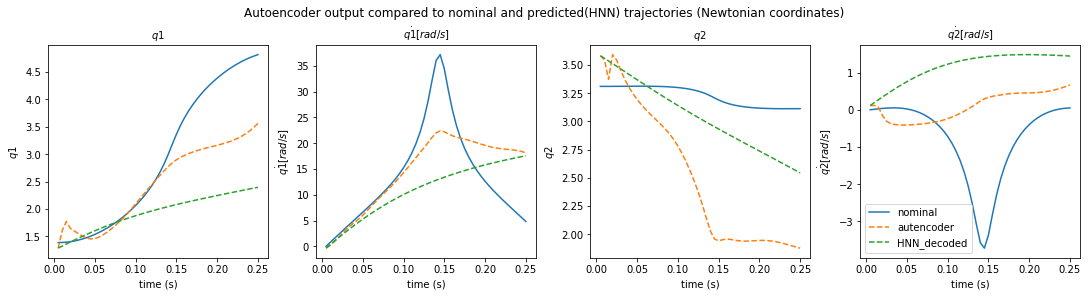

epoch  200 | train time 3.85 | train loss 2.255550e+02 
epoch  201 | train time 2.19 | train loss 1.910944e+02 
epoch  202 | train time 2.71 | train loss 1.945569e+02 
epoch  203 | train time 2.73 | train loss 1.811923e+02 
epoch  204 | train time 2.94 | train loss 1.752998e+02 
epoch  205 | train time 3.64 | train loss 1.681618e+02 
epoch  206 | train time 2.86 | train loss 1.660607e+02 
epoch  207 | train time 3.03 | train loss 1.617507e+02 
epoch  208 | train time 2.94 | train loss 1.623056e+02 
epoch  209 | train time 2.74 | train loss 1.594941e+02 


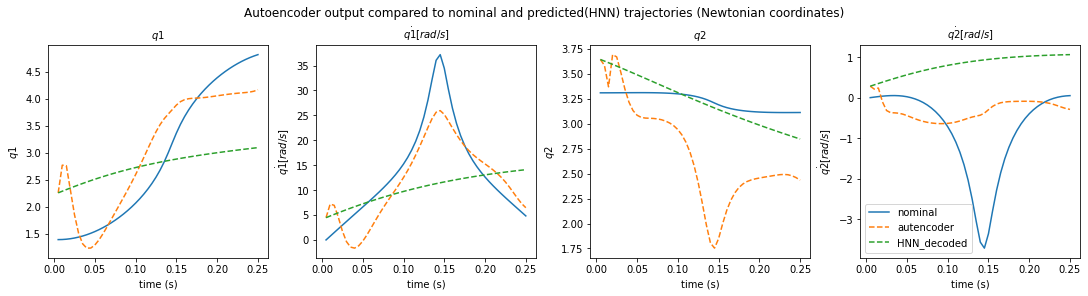

epoch  210 | train time 3.86 | train loss 1.594000e+02 
epoch  211 | train time 2.66 | train loss 1.558451e+02 
epoch  212 | train time 2.78 | train loss 1.550112e+02 
epoch  213 | train time 2.80 | train loss 1.530814e+02 
epoch  214 | train time 2.78 | train loss 1.518489e+02 
epoch  215 | train time 2.52 | train loss 1.511927e+02 
epoch  216 | train time 2.45 | train loss 1.495901e+02 
epoch  217 | train time 2.52 | train loss 1.486545e+02 
epoch  218 | train time 3.03 | train loss 1.475892e+02 
epoch  219 | train time 2.97 | train loss 1.465084e+02 


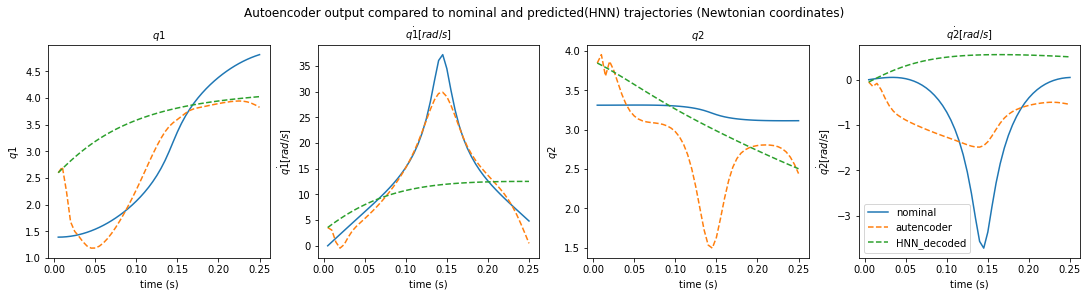

epoch  220 | train time 4.52 | train loss 1.457441e+02 
epoch  221 | train time 3.25 | train loss 1.442123e+02 


KeyboardInterrupt: 

In [13]:
stats =  train_ae(model,
                  device,
                  autoencoder, 
                  train_loader, 
                  test_loader, 
                  Ts, 
                  horizon = False, 
                  horizon_type = 'auto',
                  horizon_list = horizon_list, 
                  switch_steps = switch_steps,
                  steps_ae = 0,
                  epoch_number = epoch_number,
                  w=torch.tensor([10.0,  1.0, 100.0, 1.0], device=device))

In [ ]:
## saving stats to txt file
import json

PATH = './drive/MyDrive/1_SP_Ham_func/'
stats_path = PATH+'stats/'+save_prefix+'stats.txt'

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

In [ ]:
# save model to disk

save_prefix = 'UODEHNN_usedwithae'
model_name = 'models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [ ]:

save_prefix = 'UODEHNN_usedwithae'
model_name = 'models/'+save_prefix+'model_test'
model = load_model(hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

In [ ]:
# save AE model to disk

save_prefix = 'AE'
model_name = 'models/'+save_prefix+'model_test'
torch.save(autoencoder.state_dict(), PATH+model_name)

In [ ]:
save_prefix = 'AE'
model_name = 'models/'+save_prefix+'model_test'
autoencoder = Autoencoder(nb_hidden_layers=1,  hidden_dim=90, activation='tanh', config = 'latent') # 'x+sin(x)^2'
autoencoder.to(device)

autoencoder.load_state_dict(torch.load(PATH+model_name))
autoencoder.eval()

In [ ]:
save_stats(PATH+'aeonly', stats_2, stats_path)

In [ ]:
save_stats(PATH+'aeandHNNstats', stats, stats_path)

In [ ]:
torch.save(train_loader_newt, PATH + 'train_loader_newt.pt')

In [ ]:
train_loader_newt = torch.load(PATH + 'train_loader_newt.pt')

##### plots

In [31]:
train_steps=290
n=70
max_timestep= 800
save_prefix = 'AUTOENCODER_MODEL_nozoom_n70_twoplots'

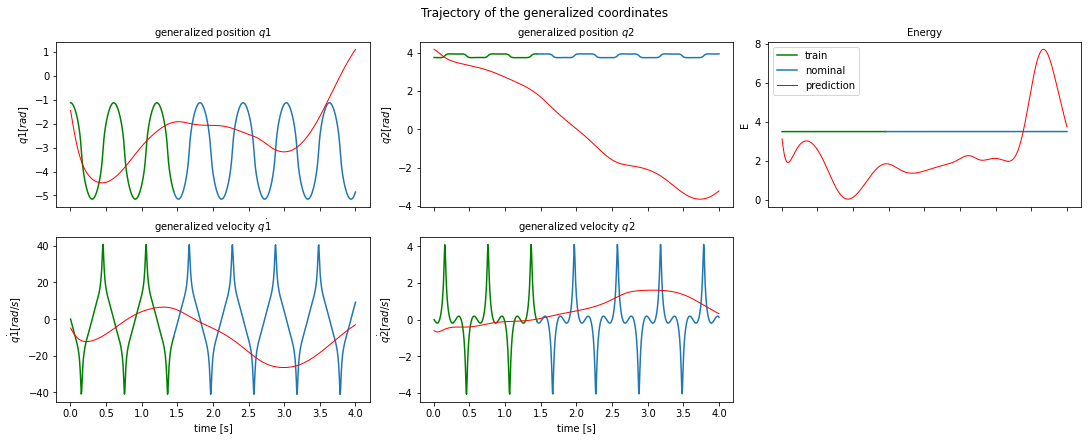

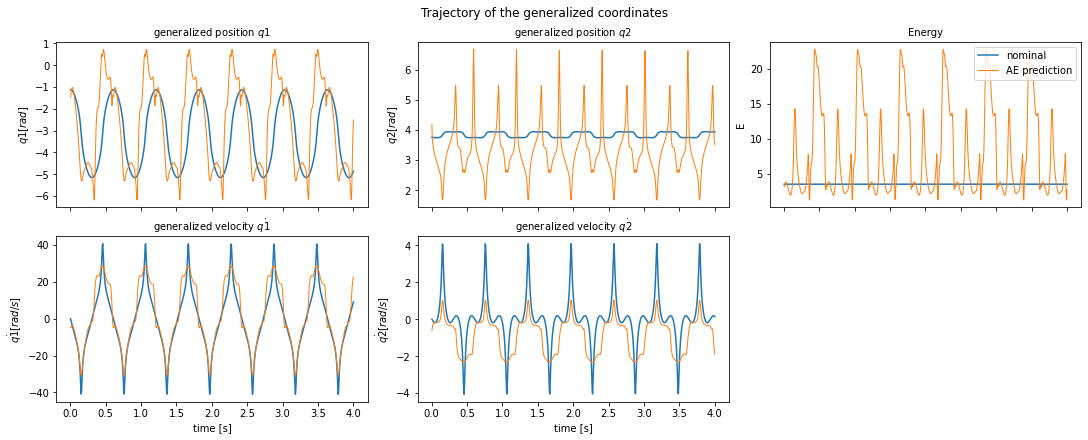

In [35]:
plot_furuta_ae_twoplots(model, 
                        autoencoder, 
                        train_loader,
                        max_timestep,
                        n,
                        train_steps, time_steps, device,
                        Ts, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                        title = 'Trajectory of the generalized coordinates', 
                        file_path = PATH+'data/'+save_prefix+'TRAJECTORIES_test_set')